<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Lections/02L_Introduction_NNs_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение в биологии

### Лекция 2: Работа в PyTorch. Создание и обучение нейронной сети.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from tqdm.auto import tqdm

In [ ]:
%matplotlib inline

### Повторение: Линейный классификатор

Давайте вспомним простейший метод регрессии - а именно линейную регрессию и попытаемся ей аппроксимировать вот такую функцию.

In [ ]:
def fun(x):
    return x * np.sin(x * 2 * np.pi) + np.exp(x ** 3) + np.random.normal(0, 0.1, x.shape)

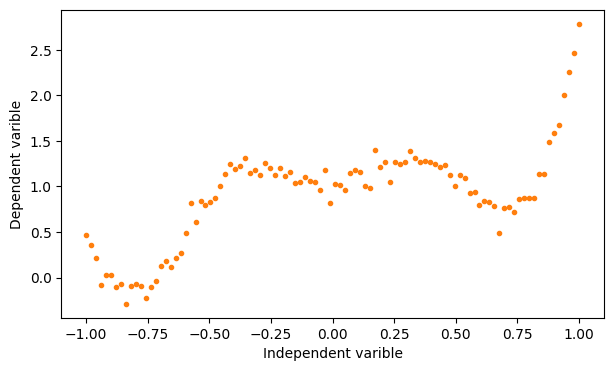

In [ ]:
from sklearn.linear_model import LinearRegression

x_np = np.linspace(-1, 1, 100).reshape(-1, 1)
y_np = fun(x_np)

# view data
plt.figure(figsize=(7, 4))
plt.scatter(x_np, y_np, marker=".", color="C1")
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()

Попытаемся обучить регрессор и посмотрим что получится.

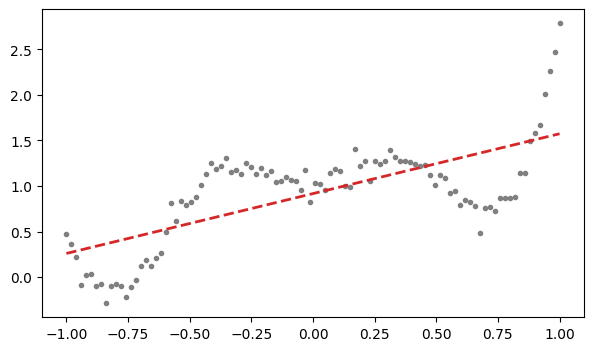

In [ ]:
regressor = LinearRegression()

regressor.fit(x_np, y_np)
prediction = regressor.predict(x_np)

plt.figure(figsize=(7, 4))
plt.scatter(x_np, y_np, marker=".", color="grey")
plt.plot(x_np, prediction, color="C3", linestyle="--", lw=2)
plt.show()

Линейная регрессия довольно плохо справляется с нелинейными данными.


#Нейронные сети

Рассказ про нейросети часто начинают с того, что они произошли от математической модели, вдохновленной биологическим нейроном. В такой простой модели "нейрон" получает входящий сигнал по "дендритам". Затем по "аксону" - выходному каналу - отправляет сигнал к остальным нейронам сети, которые либо остаются неактивными, либо активируются, распространяя сигнал далее.

Несмотря на то, что нейроны (и мозг) на самом деле работают значительно сложнее, чем искусственная нейронная сеть, модель оказалась рабочей и применимой.

С самого начала имелась проблема вычислительной сложности для полноценных запусков и масштабного использования нейронных сетей из-за их крайне высокой вычислительной сложности.

Прорывом в их использовании в наши дни мы обязаны далеко не в последнюю очередь развитию вычислительных технологий.

![neuron_biological](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/neuron_biological.png)

## Обучение нейронной сети

Обучение нейронных сетей устроено по следующей схеме:

![nn_training_scheme](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/nn_training_scheme_simplified.png)

**Данные** подаются в **модель** (нейронную сеть), в соответствии с которыми она выдает определенный ответ. На отличие результата работы сети от правильного ответа накладывается **функция потерь** (loss function), от которой можно вычислить градиент по весам модели. По этим значениям градиента производится обновление весов **оптимизатором**.

Мы видим как минимум 4 основных компонента сети:

1. Данные,
2. Сама нейросеть и заданные ее весами правила вычислений,
3. Функция потерь,
4. Оптимизатор.

Разберем каждый из компонентов поподробнее

### Класс `nn.Module`

В модуле PyTorch нейронная сеть определяется взятием подкласса для класса `torch.nn.Module`.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
nn.Module

torch.nn.modules.module.Module

У такого подкласса должно быть определено 2 основных метода:

1. `__init__` - магический метод, в котором **в атрибутах** объекта должны быть записаны преобразования нейронной сети (обычно называемые слоями)

2. `forward` - метод, определяющий то, каким образом необходимо применить слои к входным данным (аргумент `x`).

Напишем простую линейную регрессию с помощью `nn.Module`:

In [ ]:
class SimpleLinearRegression(nn.Module):
    def __init__(self, n_feature, n_output):
        super().__init__()  # Mandatory call!
        self.linear = nn.Linear(n_feature, n_output, bias=True)

    def forward(self, x):
        x = self.linear(x)
        return x

На самом деле, написание конкретно этого модуля было довольно бесполезно: внутри него мы не делаем ничего помимо создания и вызова блока `nn.Linear`.

`nn.Linear` тоже является модулем `nn.Module`:

In [ ]:
issubclass(nn.Linear, nn.Module)

True

Но давайте в учебных целях используем наш класс для того, чтобы обучить модель. Процедура обучения линейной регрессии и немного более сложной (но все еще простой) нейросети будет фактически одинаковой!

In [ ]:
model = SimpleLinearRegression(n_feature=1, n_output=1)
model

SimpleLinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

### Функция потерь

Функция потерь предназначена для того, чтобы оценивать степень "неправильности" работы модели.

Функции потерь бывают разные, и их выбор зависит от того, какие ограничения и штрафы вы хотите наложить на вашу модель.

Для линейной регрессии можно применить стандартный метод OLS, подразумевающий минимизацию среднеквадратичного отклонения (MSE):

In [ ]:
loss_fn = nn.MSELoss()

### Оптимизация: градиентный спуск

Вначале у нас есть несколько слоев нейронной сети, на вход подаем наши данные, на выходе ожидаем увидеть ответ от сети. От входного слоя нейронов сигнал отправляется к скрытому. Рассмотрим подробнее один нейрон скрытого слоя.  

Взвешенная сумма сигналов ($x$ - значение сигнала от нейрона, $w$ - вес) с предыдущего слоя со смещением $b$ подается на вход функции активации нейрона. Значение вычисляется и подается далее.

То что мы хотим получить от прямого пути (forward pass) - это результат преобразований входного сигнала скрытыми слоями.

На этапе обучения, ожидаемо, ответ будет отличаться от правильного (если сеть еще не обучена). Чтобы обучить сеть выдавать более правдоподобные результаты, нам нужно каким-то образом менять веса (параметры модели). В нейронной сети это делается с помощью функции обратного распространения ошибки (backward).

![backpropagation](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/backprop_anim.gif)

#### Градиенты и минимизация ошибки

Здесь все так же как и в других областях. Если мы хотим найти минимум функции многих переменных - нам нужно искать градиент. Напомню, градиент - это вектор, в направление максимального роста функции. Или же, взятый со знаком минус - указывающий в направлении ее убывания.

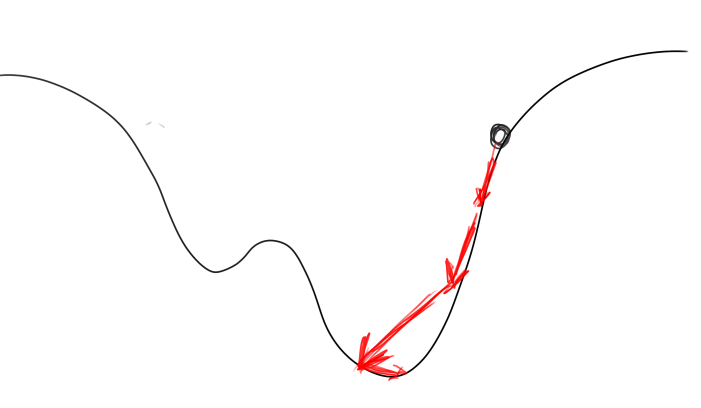

Рассмотрим на примере ошибки MSE, как искать градиент.

#### Обратное распространение ошибки; Chain Rule

Когда мы получили предсказание, нам надо сравнить его с правильным ответом из нашей обучающей выборки. Тут мы применяем функцию ошибки.


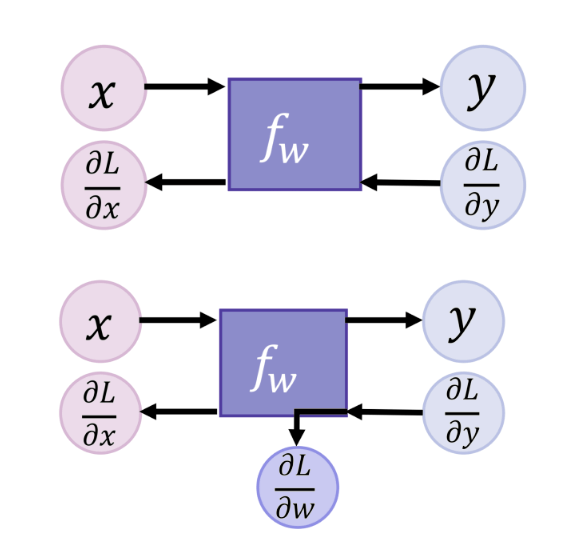

Здесь нам сильно пригождается локальная дифференцируемость функций активации, которые мы использовали. Благодаря этому, мы можем расчитывать производную сложной функции, и считать градиент последовательно по слоям от последнего к первому.

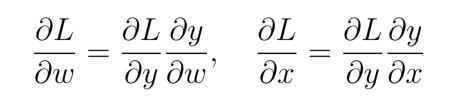

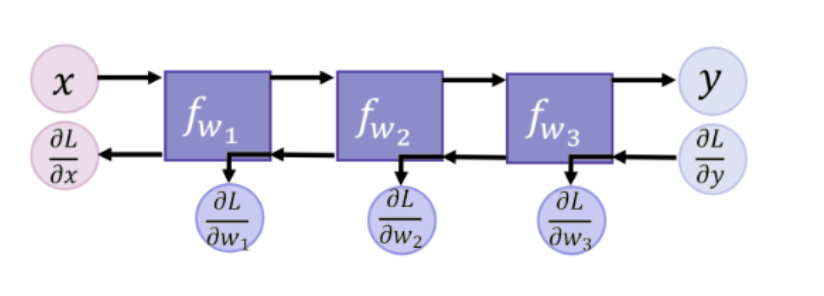

#### Оптимизатор

Оптимизатор - сущность, осуществляющая автоматическое обновление весов согласно полученным значениям частных производных функции потерь по весам.

Для нашей задачи воспользуемся оптимизатором SGD (stochastic gradient descent) - классический градиентный спуск. Почему он является стохастическим, обсудим позднее.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

С помощью вызова метода `model.parameters` мы передали оптимизатору все обучаемые параметры нейронной сети (в нашем примере 2 параметра - коэффициент наклона и свободный член).

Также мы установили коэффициент, на который будет домножаться значение градиента перед вычитанием из веса - Learning Rate (`lr`). Обычно $LR << 1$, но не всегда.

### Шаг обучения

Вот мы и дошли до обучения! На каждом шаге мы:

1. Вычисляем предсказание модели,
2. Считаем функцию потерь,
3. Обнуляем сохраненный оптимизатором градиент (он не обнуляется автоматически, т.к. это иногда бывает нужно),
4. Вычисляем градиент от функции потерь (веса модели помечены как требующие сохранения градиентов, а данные - нет),
5. Делаем шаг обновления весов оптимизатором.

In [ ]:
x, y = torch.from_numpy(x_np.astype(np.float32)), torch.from_numpy(y_np.astype(np.float32))

In [ ]:
steps = 1000
model.train()
for t in range(steps):
    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

После обучения нужно перевести модель в режим предсказания (для слоев `nn.Linear` это неважно)

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model(x)
    loss = loss_fn(prediction, y)
print(loss)

tensor(0.1581)


Визуализируем результат:

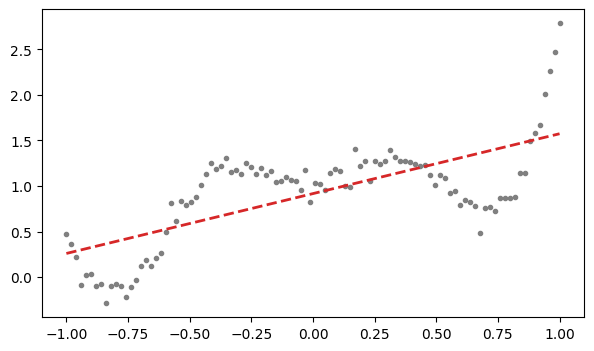

In [ ]:
plt.figure(figsize=(7, 4))
plt.scatter(x.numpy(), y.numpy(), marker=".", color="grey")
plt.plot(x.numpy(), prediction.numpy(), color="C3", linestyle="--", lw=2)
plt.show()

## Оптимизация нелинейных функций

Что же делает нейронные сети такими особенными и с какого момента они помогут нам решать проблемы нелинейности в данных?

Давайте попробуем построить простейшую нейронную сеть последовательно, пытаясь понять, каким образом она сможет распознать нелинейность.

![neuron_linear](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/neuron_linear.png)

Как мы видели выше, линейная регрессия не смогла эффективно аппроксимировать нашу функцию.

Давайте попытаемся добавить функцию активации. Существует ограничение на функции активации, которые можно использовать для обучения: они должны быть локально дифференцируемыми.

Если это условие выполняется, то мы сможем выявлять нелинейные зависимости.

![neuron_nonlinear](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/neuron_nonlinear.png)

Напишем нейронную сеть, добавив в нее какую-нибудь функцию активации:

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.1393)


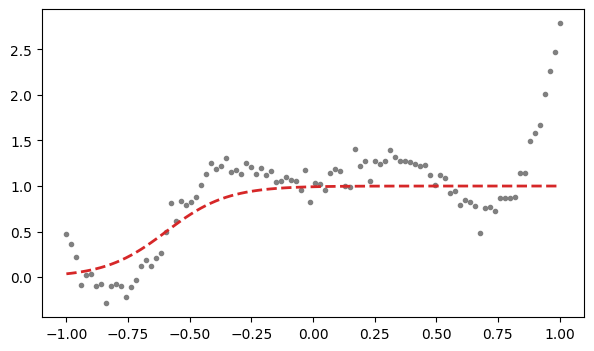

In [ ]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self, n_feature, n_output):
        super().__init__()
        self.activation = nn.Sigmoid()
        self.linear = nn.Linear(n_feature, n_output, bias=True)

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

model = SimpleLogisticRegression(n_feature=1, n_output=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

x, y = torch.from_numpy(x_np.astype(np.float32)), torch.from_numpy(y_np.astype(np.float32))

steps = 10000
model.train()
for t in tqdm(range(steps)):
    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    prediction = model(x)
    loss = loss_fn(pred, y)
print(loss)

plt.figure(figsize=(7, 4))
plt.scatter(x.numpy(), y.numpy(), marker=".", color="grey")
plt.plot(x.numpy(), prediction.numpy(), color="C3", linestyle="--", lw=2)
plt.show()

Уже лучше, но мы по-прежнему не можем достигнуть достойных результатов. _Почему?_

Давайте вместо активации попробуем **добавить дополнительный слой**.

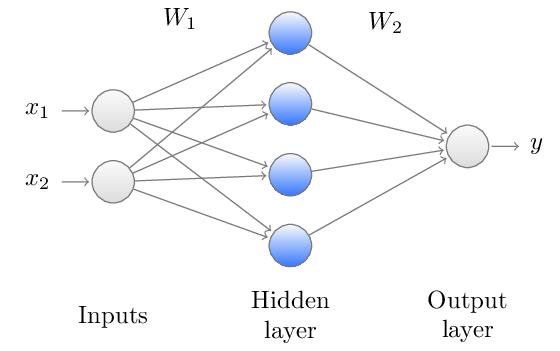

В базовом своем виде простая по архитектуре нейронная сеть будет выглядеть как несколько последовательных слоев нейронов, в которой каждый нейрон из последующего слоя связан со всеми предыдущими.

Первый слой отвечает за принятие входных данных, последний - за результат работы модели. Слои между ними называются скрытыми. Сами связи нейронов имеют веса, которые нужны для вычисления итогового результата.

Для чего вообще используются нейронные сети? Для все тех же задач машинного обучения и аппроксимации функций.

Добавим в нашу сеть второй (скрытый) слой - без активации.

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.1581)


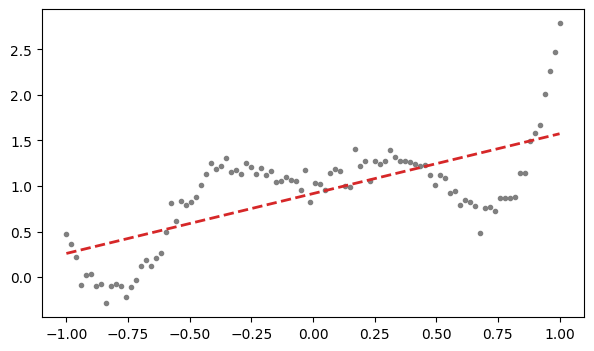

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        #self.activation = nn.Sigmoid()
        self.linear1 = nn.Linear(n_feature, n_hidden, bias=True)
        self.linear2 = nn.Linear(n_hidden, n_output, bias=True)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

model = SimpleNet(n_feature=1, n_hidden=10, n_output=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

x, y = torch.from_numpy(x_np.astype(np.float32)), torch.from_numpy(y_np.astype(np.float32))

steps = 10_000
model.train()
for t in tqdm(range(steps)):
    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    prediction = model(x)
    loss = loss_fn(pred, y)
print(loss)

plt.figure(figsize=(7, 4))
plt.scatter(x.numpy(), y.numpy(), marker=".", color="grey")
plt.plot(x.numpy(), prediction.numpy(), color="C3", linestyle="--", lw=2)
plt.show()

Все еще линейная регрессия? А если добавить активацию?

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor(0.0079)


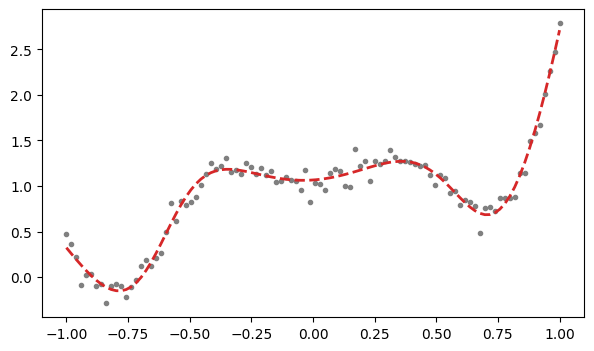

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.activation = nn.Sigmoid()
        self.linear1 = nn.Linear(n_feature, n_hidden, bias=True)
        self.linear2 = nn.Linear(n_hidden, n_output, bias=True)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

model = SimpleNet(n_feature=1, n_hidden=10, n_output=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

x, y = torch.from_numpy(x_np.astype(np.float32)), torch.from_numpy(y_np.astype(np.float32))

steps = 100_000
model.train()
for t in tqdm(range(steps)):
    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    prediction = model(x)
    loss = loss_fn(pred, y)
print(loss)

plt.figure(figsize=(7, 4))
plt.scatter(x.numpy(), y.numpy(), marker=".", color="grey")
plt.plot(x.numpy(), prediction.numpy(), color="C3", linestyle="--", lw=2)
plt.show()

### Теорема об универсальном аппроксиматоре

По теореме Цыбенко, нейронная сеть является универсальным аппроксиматором. Для выполнения этого свойства достаточно одного скрытого слоя.

### Функции Активации

![neuron_nonlinear](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/neuron_nonlinear.png)

Функция активации определяет, каким будет выход нейрона в зависимости от взвешенной суммы весов сигналов входных нейронов.

Без функции активации все операции, производимые в нейронной сети, сводились бы к линейному преобразаванию.

#### Step

Предлагалась в самых первых моделях нейронных сетей. Представляет исторический интерес. Нейрон активировался и посылал единицу, когда взвешенная сумма входов была выше нуля, и ноль в обратном случае.

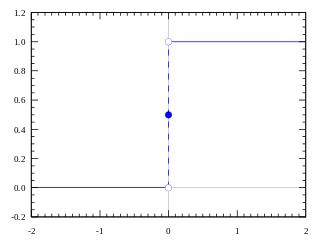

В чем проблема этой функции?

#### Sigmoid

Одна из самых распространенных в старых архитектурах функций активации. Нелинейна, хорошо подходит для задач классификации.

При определенных условиях может приводить к проблемам затуханиия градиента.

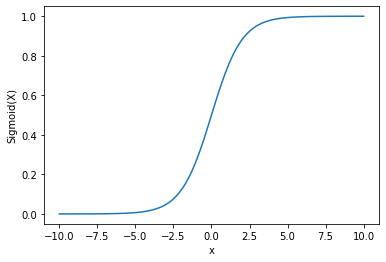

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

x = np.linspace(-10, 10, 100)
z = 1/(1 + np.exp(-x))

plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")

plt.show()

#### Tanh

Функция, по своим свойствам очень похожая на сигмоиду. По сути является модифицированной сигмоидой.

Удобно, что функция центрирована около 0.

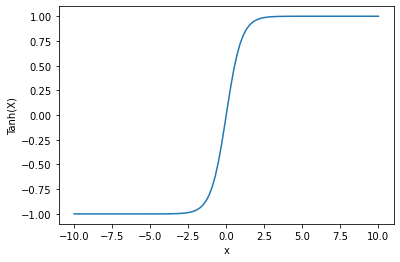

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

x = np.linspace(-10, 10, 100)
z = np.tanh(x)

plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Tanh(X)")

plt.show()

#### ReLU

Крайне популярная функция активации.

В отличие от сигмоиды и гиперболического тангенса, вычисляется быстрее, но чуствительна к аккуратному подбору шага обучения.

Может приводить к ситуациям, когда какой-то определенный нейрон во время обучения "выключается" и выпадает из процесса обучения, - "смерти" нейронов.

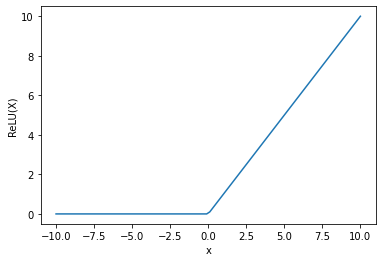

In [ ]:
import torch

relu = torch.nn.ReLU()

x = torch.linspace(-10, 10, 100)
z = relu(x)

plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("ReLU(X)")

plt.show()

### Модели с разными функциями активации

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, activation_cls=nn.Sigmoid):
        super().__init__()
        self.activation = activation_cls()
        self.linear1 = nn.Linear(n_feature, n_hidden, bias=True)
        self.linear2 = nn.Linear(n_hidden, n_output, bias=True)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [ ]:
def fit_with_chart(x_np, y_np, n_feature, n_hidden, n_output, activation_cls, lr, steps):
    model = SimpleNet(
        n_feature=n_feature,
        n_hidden=n_hidden,
        n_output=n_output,
        activation_cls=activation_cls,
    )
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    x, y = torch.from_numpy(x_np.astype(np.float32)), torch.from_numpy(y_np.astype(np.float32))

    steps = steps
    model.train()
    for t in tqdm(range(1, steps + 1)):
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        prediction = model(x)
        loss = loss_fn(prediction, y)
    print(loss)

    plt.figure(figsize=(7, 4))
    plt.scatter(x.numpy(), y.numpy(), marker=".", color="grey")
    plt.plot(x.numpy(), prediction.numpy(), color="C3", linestyle="--", lw=2)
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0104)


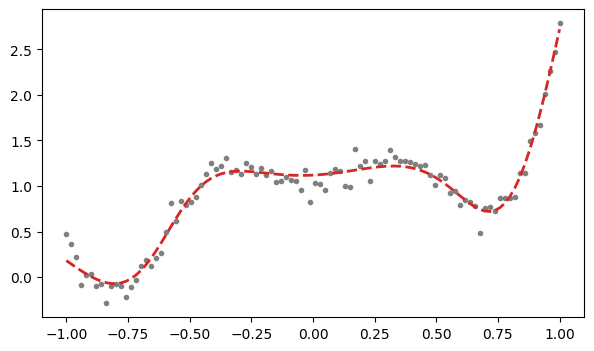

In [ ]:
fit_with_chart(x_np, y_np, 1, 10, 1, nn.Tanh, 0.1, 10_000)

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor(0.0280)


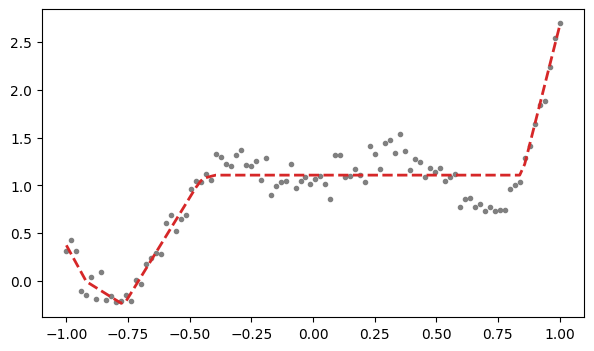

In [ ]:
fit_with_chart(x_np, y_np, 1, 100, 1, nn.ReLU, 0.1, 100_000)

Как это работает:

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/combinations_relu.png" width="600" />

![self-folding](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/self_folding.png)

Источник: Prince, 2023

## Вспомогательные классы PyTorch

### `nn.Sequential`

`nn.Sequential` позволяет объединять слои внутри модели в один и работать с ними как с одним слоем. Модифицируем нашу модель:

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, activation_cls=nn.Sigmoid):
        super().__init__()
        self.bilinear = nn.Sequential(
            nn.Linear(n_feature, n_hidden, bias=True),
            activation_cls(),
            nn.Linear(n_hidden, n_output, bias=True),
        )

    def forward(self, x):
        x = self.bilinear(x)
        return x

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0137)


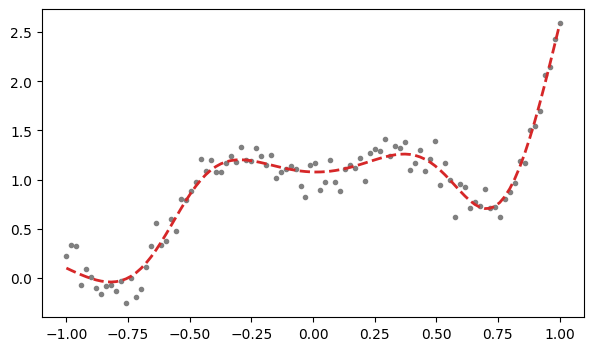

In [ ]:
fit_with_chart(x_np, y_np, 1, 10, 1, nn.Tanh, 0.1, 10_000)

В случае такой простой модели, вполне достаточно написать

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 10, bias=True),
    nn.Tanh(),
    nn.Linear(10, 1, bias=True),
)

### Работа с MiniBatch'ами

Другим важным концептом при работе с нейронными сетями являяются minibatch'и, которые зачастую называют просто "батчами". Минибатч - это ограниченная часть входных данных.

Во всех рассмотренных ранее схемах мы подавали все объекты сразу, и сразу же вычисляем ошибку по всем объектам.

Подсчет градиента и обновления весов - очень вычислительнозатратная процедура, полный датасет может не поместиться в памяти графического или тензорного ускорителя.

Это существенно упрощает работу с данными. Одновременно с этим, это влияет на качество обучения - чем больше элементов в батче, тем реже мы обновляем параметры и тем меньше наша ошибка выцепляет специфичные для отдельного элемента параметры. Скорость обучения растет, качество предсказания падает.
Использование батчей не только ускоряет работу, но и меняет характер обучения.

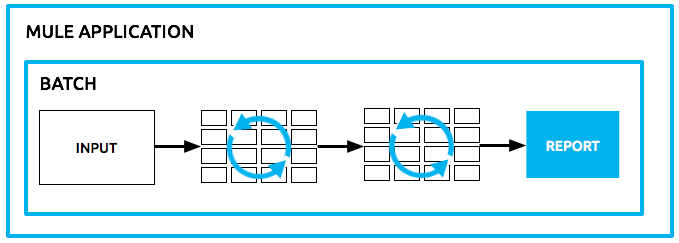

В случае использования минибатчей, схема **одного шага** обучения выглядит так:

![nn_training_scheme](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/nn_training_scheme.png)

Согласно исследованиям, использование батчей может даже улучшать результаты обучения.

#### Dataset и DataLoader

По-хорошему, на каждой эпохе обучения (то есть на каждом прогоне всей обучающей выборки через модель) разбивку датасета по батчам нужно менять. А еще для многих задач, нам нужно оптимизировать, трансформировать и преобразовывать элементы внутри выборок.

Для удобной работы с данными существуют классы `Dataset` и `DataLoader`.  Первый (`Dataset`) позволяет прогружать исходные данные и совершать над ними преобразования (`transform`), а второй (`DataLoader`) нужен для параллелизации процессов загрузки данных и передачи их модели.

In [ ]:
import torch
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

x, y = torch.from_numpy(x_np.astype(np.float32)), torch.from_numpy(y_np.astype(np.float32))

net = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)

train = torch.utils.data.TensorDataset(x, y)
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

steps = 2000

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()  # this is for regression mean squared loss

net.train()
for t in tqdm(range(steps)):
    for i in train_loader:
        x_batch, y_batch = i
        prediction = net(x_batch)

        loss = loss_fn(prediction, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

tensor(0.0105)


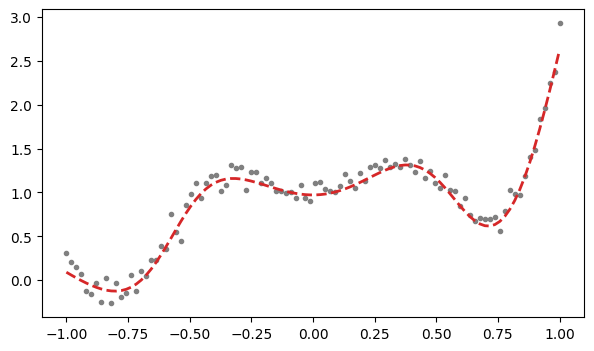

In [ ]:
net.eval()
with torch.no_grad():
    prediction = net(x)
    loss = loss_fn(prediction, y)
print(loss)

plt.figure(figsize=(7, 4))
plt.scatter(x.numpy(), y.numpy(), marker=".", color="grey")
plt.plot(x.numpy(), prediction.numpy(), color="C3", linestyle="--", lw=2)
plt.show()

## MNIST


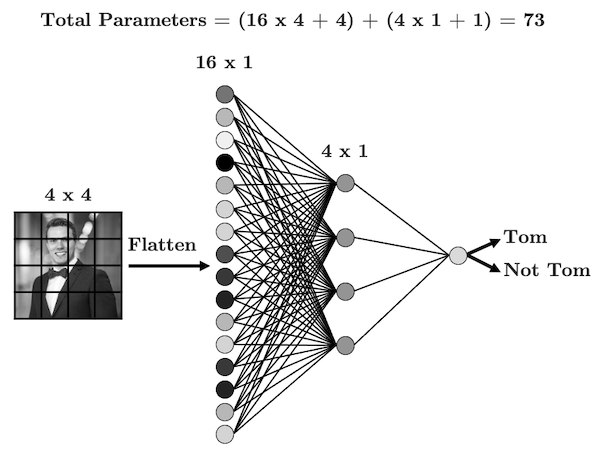

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img =  torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


model = Net()

In [ ]:
import torchvision
from torchvision.datasets import MNIST

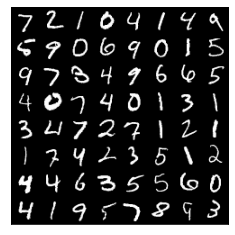

In [ ]:
trainset = MNIST(root='./MNIST', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset = MNIST(root='./MNIST', train=False, download=True, transform=torchvision.transforms.ToTensor())

batch_size = 64
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

for i in test_dataloader:
  grid = make_grid(i[0])
  show(grid)
  break

In [ ]:
learning_rate = 1e-2
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
accuracies = []
losses = []
for t in range(epochs):
    print(f"Epoch {t}\n")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    a = test_loop(test_dataloader, model, loss_fn)
    accuracies.append(a[0])
    losses.append(a[1])
print("Done!")

Epoch 0

loss: 2.311638  [    0/60000]
loss: 2.131010  [ 6400/60000]
loss: 1.709192  [12800/60000]
loss: 1.584700  [19200/60000]
loss: 1.202239  [25600/60000]
loss: 1.092856  [32000/60000]
loss: 0.941536  [38400/60000]
loss: 0.807423  [44800/60000]
loss: 0.691666  [51200/60000]
loss: 0.755180  [57600/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.591396 

Epoch 1

loss: 0.504236  [    0/60000]
loss: 0.614338  [ 6400/60000]
loss: 0.465331  [12800/60000]
loss: 0.505428  [19200/60000]
loss: 0.491907  [25600/60000]
loss: 0.565818  [32000/60000]
loss: 0.489758  [38400/60000]
loss: 0.385888  [44800/60000]
loss: 0.328967  [51200/60000]
loss: 0.404250  [57600/60000]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.407042 

Epoch 2

loss: 0.490917  [    0/60000]
loss: 0.444657  [ 6400/60000]
loss: 0.413771  [12800/60000]
loss: 0.333600  [19200/60000]
loss: 0.414006  [25600/60000]
loss: 0.328844  [32000/60000]
loss: 0.403820  [38400/60000]
loss: 0.289272  [44800/60000]
loss: 0.787730  [51200/60000]

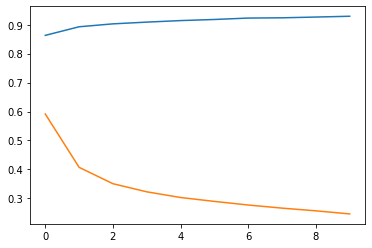

In [ ]:
plt.plot(list(range(10)), accuracies)
plt.plot(list(range(10)), losses)
plt.show()


## Применение в биологии

### Предсказание экспрессии

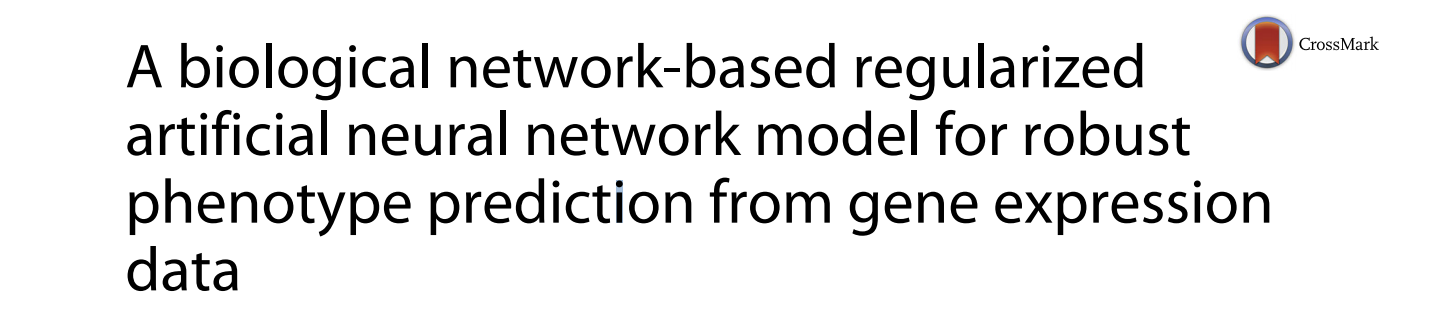

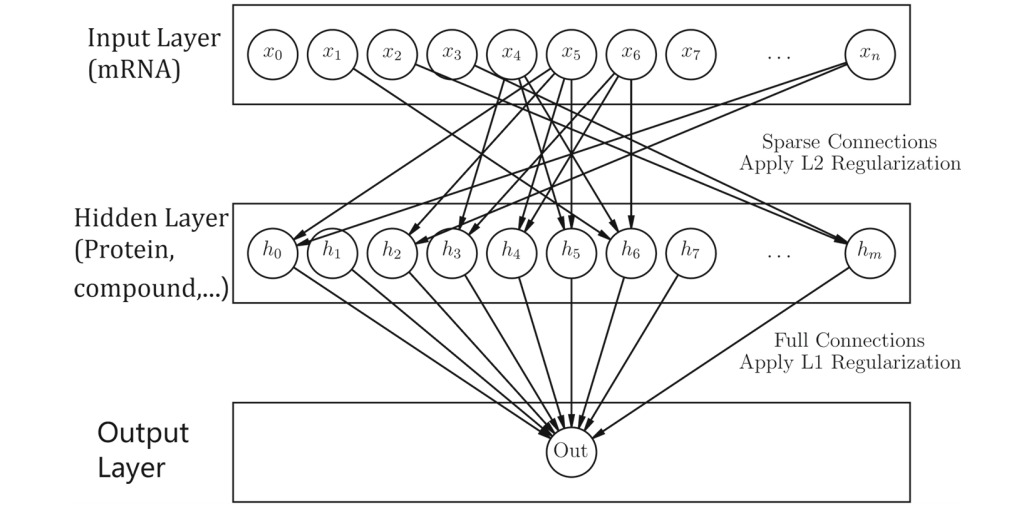

DOI 10.1186/s12859-017-1984-2

### Предсказание химических свойств

Довольно часто в задачах структурной биоинформатики, где нам важно 3D-представление молекул (например, белков и нуклеиновых кислот), возникает необходимость расчетов уровня квантовой химии, а приближений молекулярной динамики не совсем достаточно. Почти все методы квантовой вычислительной химии довольно вычислительно затратны для подобных расчетов, и эта затратность экспоненциально зависит от количества электронов в системе. Это приводит к тому, что 100-атомную молекулку посчитать можно, а вот белок из 4000 атомов уже нет.

Но нейронные сети помогают решить задачу. Один из недавных прорывов - это torchANI и другие порты нейросетевого потенциала ANI для других библиотек нейронных сетей. Заявленная нейросеть расчитывает некоторые из квантовохимических параметров значительно быстрее, с низким падением точности.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/id_l/L8_B.png" alt="alttext" width=600/>

Что интересно, сама нейросеть прдставляет собой вариант именно полносвязной нейронной сети, но с некоторыми особенностями.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/id_l/L8_05.png" alt="alttext" width=600/>

https://doi.org/10.1021/acs.jcim.0c00451


Пример установки и запуска torchANI

In [ ]:
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
!pip install torchani

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
     |████████████████████████████████| 10.8 MB 5.2 MB/s 
     |████████████████████████████████| 103 kB 49.5 MB/s 


In [ ]:
import torch
import torchani

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchani.models.ANI2x(periodic_table_index=True).to(device)

coordinates = torch.tensor([[[ 0.03192167,  0.00638559,  0.01301679],
                             [-0.83140486,  0.39370209, -0.26395324],
                             [-0.66518241, -0.84461308,  0.20759389],
                             [ 0.45554739,  0.54289633,  0.81170881],
                             [ 0.66091919, -0.16799635, -0.91037834]]],
                           requires_grad=True, device=device)

# In periodic table, C = 6 and H = 1
species = torch.tensor([[6, 1, 1, 1, 1]], device=device)

energy = model((species, coordinates)).energies
derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
force = -derivative

print('Energy:', energy.item())
print('Force:', force.squeeze())

Energy: -40.459790705366636
Force: tensor([[ 0.0478, -0.1304, -0.0551],
        [-0.1353,  0.1581, -0.0776],
        [ 0.0804, -0.0388,  0.0387],
        [ 0.0254,  0.0076,  0.0433],
        [-0.0183,  0.0035,  0.0508]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
